In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
dataset = pd.read_csv('../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [4]:
print(dataset.columns)

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['price']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (35063, 1)
stages_supervised.shape: (34968, 96)


In [7]:
stages.max()

price    116.8
dtype: float64

In [8]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
time,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00+00:00,64.92,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
2015-01-04 01:00:00+00:00,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2015-01-04 02:00:00+00:00,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
2015-01-04 03:00:00+00:00,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
2015-01-04 04:00:00+00:00,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,62.06,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 19:00:00+00:00,78.99,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
2018-12-30 20:00:00+00:00,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
2018-12-30 21:00:00+00:00,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,66.81,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30


#### Prior unknown covariates (6)

In [9]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [10]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [11]:
prior_known = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (35063, 25)
prior_known_supervised.shape: (34968, 2400)


In [12]:
# prior_known_supervised

### N_out, N_in, K

In [13]:
past_cov = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (34968, 2400)


In [14]:
# past_cov_supervised  # 6 + 9 = 15 features

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
# past_ws_supervised  # 4

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [19]:
# past_cov_ws_supervised

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var16(t+23),shift_prior_known_supervised_var17(t+23),shift_prior_known_supervised_var18(t+23),shift_prior_known_supervised_var19(t+23),shift_prior_known_supervised_var20(t+23),shift_prior_known_supervised_var21(t+23),shift_prior_known_supervised_var22(t+23),shift_prior_known_supervised_var23(t+23),shift_prior_known_supervised_var24(t+23),shift_prior_known_supervised_var25(t+23)
0,7.00,1190.0,2902.0,24935.0,0.0,192.0,61.0,1038.0,1036.0,167.0,...,156.0,21.0,1182.0,132.0,2.0,1.0,0.0,7351.0,1.0,650.0
1,5.00,1023.0,2772.0,23214.0,0.0,189.0,60.0,1037.0,1036.0,167.0,...,163.0,12.0,1099.0,132.0,1.0,1.0,0.0,7403.0,1.0,938.0
2,4.00,1016.0,2936.0,22540.0,0.0,188.0,59.0,1037.0,1036.0,181.0,...,160.0,13.0,1076.0,108.0,2.0,2.0,0.0,7887.0,1.0,1021.0
3,4.00,1103.0,2893.0,22096.0,0.0,189.0,61.0,1037.0,1037.0,181.0,...,165.0,6.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
4,4.80,1120.0,2889.0,22066.0,0.0,190.0,59.0,1038.0,1037.0,171.0,...,162.0,20.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,66.00,2931.0,9149.0,32642.0,718.0,294.0,103.0,1028.0,1033.0,314.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
34964,62.09,2889.0,8024.0,32155.0,675.0,294.0,103.0,1028.0,1033.0,315.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
34965,61.77,2871.0,6871.0,30428.0,569.0,291.0,104.0,1029.0,1033.0,314.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0
34966,58.43,2619.0,5822.0,28015.0,310.0,288.0,103.0,1029.0,1033.0,313.0,...,120.0,0.0,1128.0,60.0,5.0,2.0,1.0,3586.0,2.0,108.0


In [21]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [22]:
# shift_prior_known_past_cov_ws_supervised

In [23]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
1,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
3,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
4,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,58.56,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,73.35,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
34964,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
34965,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30
34966,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,66.64,...,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30,69.89


### Concatenation

In [24]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34968, 3696)


### Train & Test set

In [25]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 27974


In [26]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

3672

### Normalization

In [27]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (27974, 3672) (27974, 24) (6994, 3672) (6994, 24)


In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (27974, 72, 51) (27974, 24) (6994, 72, 51) (6994, 24)


### Model

In [30]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 5 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)

x1_merge2 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)

x1_merge3 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)

x1_merge4 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=16, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge4)



# 5 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x2_merge1 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)

x2_merge2 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge2)

x2_merge3 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(16, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge3)

x2_merge4 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(8, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge4)


merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(train_y.shape[1])(x)

energy_pararcnn = Model(model_input, x)
energy_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 51)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 72, 256)      26368       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_3 (SimpleRNN)        (None, 72, 128)      23040       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 72, 307)      0           input_2[0][0]                    
                                                                 conv1d_3[0][0]             

Epoch 1/6000


2023-01-06 23:31:08.057422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-06 23:31:08.276340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-06 23:31:09.479946: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-06 23:31:09.851151: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.17287, saving model to saved_model/energy_pararcnn_sc1_5layer_24h.h5
55/55 - 69s - loss: 0.3589 - mae: 0.1219 - val_loss: 0.3149 - val_mae: 0.1729
Epoch 2/6000

Epoch 00002: val_mae improved from 0.17287 to 0.11841, saving model to saved_model/energy_pararcnn_sc1_5layer_24h.h5
55/55 - 13s - loss: 0.2572 - mae: 0.0701 - val_loss: 0.2433 - val_mae: 0.1184
Epoch 3/6000

Epoch 00003: val_mae improved from 0.11841 to 0.08439, saving model to saved_model/energy_pararcnn_sc1_5layer_24h.h5
55/55 - 13s - loss: 0.2108 - mae: 0.0619 - val_loss: 0.1964 - val_mae: 0.0844
Epoch 4/6000

Epoch 00004: val_mae did not improve from 0.08439
55/55 - 13s - loss: 0.1770 - mae: 0.0583 - val_loss: 0.1679 - val_mae: 0.0855
Epoch 5/6000

Epoch 00005: val_mae improved from 0.08439 to 0.06634, saving model to saved_model/energy_pararcnn_sc1_5layer_24h.h5
55/55 - 13s - loss: 0.1510 - mae: 0.0531 - val_loss: 0.1423 - val_mae: 0.0663
Epoch 6/6000

Epoch 00006: val_mae did 

55/55 - 13s - loss: 0.0103 - mae: 0.0417 - val_loss: 0.0109 - val_mae: 0.0464
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.04638
55/55 - 12s - loss: 0.0103 - mae: 0.0431 - val_loss: 0.0110 - val_mae: 0.0485
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.04638
55/55 - 13s - loss: 0.0101 - mae: 0.0427 - val_loss: 0.0109 - val_mae: 0.0496
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.04638
55/55 - 13s - loss: 0.0099 - mae: 0.0428 - val_loss: 0.0106 - val_mae: 0.0478
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.04638
55/55 - 13s - loss: 0.0097 - mae: 0.0422 - val_loss: 0.0116 - val_mae: 0.0575
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.04638
55/55 - 13s - loss: 0.0099 - mae: 0.0447 - val_loss: 0.0103 - val_mae: 0.0483
Epoch 58/6000

Epoch 00058: val_mae did not improve from 0.04638
55/55 - 13s - loss: 0.0093 - mae: 0.0416 - val_loss: 0.0113 - val_mae: 0.0560
Epoch 59/6000

Epoch 00059: val_mae improved from 0.04638 to 0.0

Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.04451
55/55 - 12s - loss: 0.0059 - mae: 0.0402 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.04451
55/55 - 12s - loss: 0.0059 - mae: 0.0406 - val_loss: 0.0067 - val_mae: 0.0467
Epoch 109/6000

Epoch 00109: val_mae did not improve from 0.04451
55/55 - 12s - loss: 0.0059 - mae: 0.0404 - val_loss: 0.0068 - val_mae: 0.0477
Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.04451
55/55 - 13s - loss: 0.0057 - mae: 0.0395 - val_loss: 0.0066 - val_mae: 0.0462
Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.04451
55/55 - 13s - loss: 0.0058 - mae: 0.0406 - val_loss: 0.0064 - val_mae: 0.0448
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.04451
55/55 - 12s - loss: 0.0058 - mae: 0.0407 - val_loss: 0.0068 - val_mae: 0.0487
Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.04451
55/55 - 12s - loss: 0.0058 - mae: 0.0406 - val_loss: 0.0085 - val_mae:

Epoch 173/6000

Epoch 00173: val_mae did not improve from 0.04393
55/55 - 12s - loss: 0.0049 - mae: 0.0390 - val_loss: 0.0063 - val_mae: 0.0501
Epoch 174/6000

Epoch 00174: val_mae improved from 0.04393 to 0.04381, saving model to saved_model/energy_pararcnn_sc1_5layer_24h.h5
55/55 - 13s - loss: 0.0050 - mae: 0.0395 - val_loss: 0.0056 - val_mae: 0.0438
Epoch 175/6000

Epoch 00175: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0051 - mae: 0.0405 - val_loss: 0.0060 - val_mae: 0.0471
Epoch 176/6000

Epoch 00176: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0051 - mae: 0.0408 - val_loss: 0.0065 - val_mae: 0.0508
Epoch 177/6000

Epoch 00177: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0049 - mae: 0.0391 - val_loss: 0.0067 - val_mae: 0.0525
Epoch 178/6000

Epoch 00178: val_mae did not improve from 0.04381
55/55 - 13s - loss: 0.0051 - mae: 0.0402 - val_loss: 0.0063 - val_mae: 0.0495
Epoch 179/6000

Epoch 00179: val_mae did not improve from 0.04381
55/

Epoch 230/6000

Epoch 00230: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0047 - mae: 0.0384 - val_loss: 0.0059 - val_mae: 0.0475
Epoch 231/6000

Epoch 00231: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0047 - mae: 0.0385 - val_loss: 0.0057 - val_mae: 0.0461
Epoch 232/6000

Epoch 00232: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0048 - mae: 0.0391 - val_loss: 0.0056 - val_mae: 0.0452
Epoch 233/6000

Epoch 00233: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0047 - mae: 0.0387 - val_loss: 0.0056 - val_mae: 0.0458
Epoch 234/6000

Epoch 00234: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0046 - mae: 0.0381 - val_loss: 0.0059 - val_mae: 0.0483
Epoch 235/6000

Epoch 00235: val_mae did not improve from 0.04381
55/55 - 12s - loss: 0.0047 - mae: 0.0386 - val_loss: 0.0065 - val_mae: 0.0535
Epoch 236/6000

Epoch 00236: val_mae did not improve from 0.04381
55/55 - 13s - loss: 0.0048 - mae: 0.0394 - val_loss: 0.0060 - val_mae:

Epoch 286/6000

Epoch 00286: val_mae did not improve from 0.04332
55/55 - 12s - loss: 0.0045 - mae: 0.0379 - val_loss: 0.0062 - val_mae: 0.0517
Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.04332
55/55 - 12s - loss: 0.0045 - mae: 0.0380 - val_loss: 0.0055 - val_mae: 0.0460
Epoch 288/6000

Epoch 00288: val_mae did not improve from 0.04332
55/55 - 12s - loss: 0.0045 - mae: 0.0382 - val_loss: 0.0056 - val_mae: 0.0459
Epoch 289/6000

Epoch 00289: val_mae did not improve from 0.04332
55/55 - 12s - loss: 0.0045 - mae: 0.0385 - val_loss: 0.0054 - val_mae: 0.0446
Epoch 290/6000

Epoch 00290: val_mae did not improve from 0.04332
55/55 - 12s - loss: 0.0046 - mae: 0.0390 - val_loss: 0.0067 - val_mae: 0.0554
Epoch 291/6000

Epoch 00291: val_mae did not improve from 0.04332
55/55 - 12s - loss: 0.0046 - mae: 0.0385 - val_loss: 0.0066 - val_mae: 0.0541
Epoch 292/6000

Epoch 00292: val_mae did not improve from 0.04332
55/55 - 13s - loss: 0.0045 - mae: 0.0384 - val_loss: 0.0067 - val_mae:

Epoch 342/6000

Epoch 00342: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0377 - val_loss: 0.0057 - val_mae: 0.0477
Epoch 343/6000

Epoch 00343: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0381 - val_loss: 0.0053 - val_mae: 0.0443
Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0057 - val_mae: 0.0478
Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0054 - val_mae: 0.0451
Epoch 346/6000

Epoch 00346: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0067 - val_mae: 0.0557
Epoch 347/6000

Epoch 00347: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0045 - mae: 0.0388 - val_loss: 0.0061 - val_mae: 0.0509
Epoch 348/6000

Epoch 00348: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0382 - val_loss: 0.0064 - val_mae:

Epoch 399/6000

Epoch 00399: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0383 - val_loss: 0.0058 - val_mae: 0.0491
Epoch 400/6000

Epoch 00400: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0044 - mae: 0.0379 - val_loss: 0.0063 - val_mae: 0.0528
Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0056 - val_mae: 0.0476
Epoch 402/6000

Epoch 00402: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0053 - val_mae: 0.0445
Epoch 403/6000

Epoch 00403: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0385 - val_loss: 0.0058 - val_mae: 0.0497
Epoch 404/6000

Epoch 00404: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0386 - val_loss: 0.0065 - val_mae: 0.0548
Epoch 405/6000

Epoch 00405: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0377 - val_loss: 0.0053 - val_mae:

Epoch 456/6000

Epoch 00456: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0053 - val_mae: 0.0455
Epoch 457/6000

Epoch 00457: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0057 - val_mae: 0.0497
Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0376 - val_loss: 0.0053 - val_mae: 0.0457
Epoch 459/6000

Epoch 00459: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0051 - val_mae: 0.0437
Epoch 460/6000

Epoch 00460: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0378 - val_loss: 0.0060 - val_mae: 0.0509
Epoch 461/6000

Epoch 00461: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0044 - mae: 0.0387 - val_loss: 0.0054 - val_mae: 0.0461
Epoch 462/6000

Epoch 00462: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0044 - mae: 0.0386 - val_loss: 0.0061 - val_mae:

Epoch 513/6000

Epoch 00513: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0367 - val_loss: 0.0057 - val_mae: 0.0485
Epoch 514/6000

Epoch 00514: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0055 - val_mae: 0.0465
Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0389 - val_loss: 0.0061 - val_mae: 0.0516
Epoch 516/6000

Epoch 00516: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0058 - val_mae: 0.0499
Epoch 517/6000

Epoch 00517: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0390 - val_loss: 0.0054 - val_mae: 0.0463
Epoch 518/6000

Epoch 00518: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0058 - val_mae: 0.0494
Epoch 519/6000

Epoch 00519: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0055 - val_mae:

Epoch 570/6000

Epoch 00570: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0052 - val_mae: 0.0451
Epoch 571/6000

Epoch 00571: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0379 - val_loss: 0.0060 - val_mae: 0.0514
Epoch 572/6000

Epoch 00572: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0044 - mae: 0.0386 - val_loss: 0.0060 - val_mae: 0.0514
Epoch 573/6000

Epoch 00573: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0053 - val_mae: 0.0460
Epoch 574/6000

Epoch 00574: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0061 - val_mae: 0.0512
Epoch 575/6000

Epoch 00575: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0058 - val_mae: 0.0493
Epoch 576/6000

Epoch 00576: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0050 - val_mae:

Epoch 627/6000

Epoch 00627: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0057 - val_mae: 0.0487
Epoch 628/6000

Epoch 00628: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0064 - val_mae: 0.0541
Epoch 629/6000

Epoch 00629: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0052 - val_mae: 0.0448
Epoch 630/6000

Epoch 00630: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0068 - val_mae: 0.0569
Epoch 631/6000

Epoch 00631: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0380 - val_loss: 0.0062 - val_mae: 0.0525
Epoch 632/6000

Epoch 00632: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0052 - val_mae: 0.0449
Epoch 633/6000

Epoch 00633: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0056 - val_mae:

Epoch 684/6000

Epoch 00684: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0066 - val_mae: 0.0558
Epoch 685/6000

Epoch 00685: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0063 - val_mae: 0.0535
Epoch 686/6000

Epoch 00686: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0056 - val_mae: 0.0484
Epoch 687/6000

Epoch 00687: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0064 - val_mae: 0.0545
Epoch 688/6000

Epoch 00688: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0041 - mae: 0.0363 - val_loss: 0.0057 - val_mae: 0.0492
Epoch 689/6000

Epoch 00689: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0052 - val_mae: 0.0453
Epoch 690/6000

Epoch 00690: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0057 - val_mae:

Epoch 741/6000

Epoch 00741: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0054 - val_mae: 0.0473
Epoch 742/6000

Epoch 00742: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0053 - val_mae: 0.0458
Epoch 743/6000

Epoch 00743: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0059 - val_mae: 0.0515
Epoch 744/6000

Epoch 00744: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0378 - val_loss: 0.0053 - val_mae: 0.0463
Epoch 745/6000

Epoch 00745: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0055 - val_mae: 0.0478
Epoch 746/6000

Epoch 00746: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0052 - val_mae: 0.0452
Epoch 747/6000

Epoch 00747: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0061 - val_mae:

Epoch 798/6000

Epoch 00798: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0372 - val_loss: 0.0063 - val_mae: 0.0545
Epoch 799/6000

Epoch 00799: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0379 - val_loss: 0.0055 - val_mae: 0.0473
Epoch 800/6000

Epoch 00800: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0055 - val_mae: 0.0473
Epoch 801/6000

Epoch 00801: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0056 - val_mae: 0.0483
Epoch 802/6000

Epoch 00802: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0056 - val_mae: 0.0478
Epoch 803/6000

Epoch 00803: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0058 - val_mae: 0.0494
Epoch 804/6000

Epoch 00804: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0054 - val_mae:

Epoch 855/6000

Epoch 00855: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0053 - val_mae: 0.0462
Epoch 856/6000

Epoch 00856: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0062 - val_mae: 0.0527
Epoch 857/6000

Epoch 00857: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0376 - val_loss: 0.0052 - val_mae: 0.0454
Epoch 858/6000

Epoch 00858: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0064 - val_mae: 0.0537
Epoch 859/6000

Epoch 00859: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0060 - val_mae: 0.0512
Epoch 860/6000

Epoch 00860: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0055 - val_mae: 0.0473
Epoch 861/6000

Epoch 00861: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0050 - val_mae:

Epoch 912/6000

Epoch 00912: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0056 - val_mae: 0.0487
Epoch 913/6000

Epoch 00913: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0051 - val_mae: 0.0446
Epoch 914/6000

Epoch 00914: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0365 - val_loss: 0.0055 - val_mae: 0.0481
Epoch 915/6000

Epoch 00915: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0384 - val_loss: 0.0056 - val_mae: 0.0482
Epoch 916/6000

Epoch 00916: val_mae did not improve from 0.04271
55/55 - 13s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0055 - val_mae: 0.0475
Epoch 917/6000

Epoch 00917: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0054 - val_mae: 0.0468
Epoch 918/6000

Epoch 00918: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0375 - val_loss: 0.0050 - val_mae:

Epoch 969/6000

Epoch 00969: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0383 - val_loss: 0.0058 - val_mae: 0.0498
Epoch 970/6000

Epoch 00970: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0362 - val_loss: 0.0053 - val_mae: 0.0463
Epoch 971/6000

Epoch 00971: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0058 - val_mae: 0.0504
Epoch 972/6000

Epoch 00972: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0054 - val_mae: 0.0468
Epoch 973/6000

Epoch 00973: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0378 - val_loss: 0.0056 - val_mae: 0.0478
Epoch 974/6000

Epoch 00974: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0055 - val_mae: 0.0481
Epoch 975/6000

Epoch 00975: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0042 - mae: 0.0377 - val_loss: 0.0055 - val_mae:

Epoch 1026/6000

Epoch 01026: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0068 - val_mae: 0.0580
Epoch 1027/6000

Epoch 01027: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0384 - val_loss: 0.0050 - val_mae: 0.0436
Epoch 1028/6000

Epoch 01028: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0062 - val_mae: 0.0530
Epoch 1029/6000

Epoch 01029: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0052 - val_mae: 0.0452
Epoch 1030/6000

Epoch 01030: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0376 - val_loss: 0.0053 - val_mae: 0.0464
Epoch 1031/6000

Epoch 01031: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0043 - mae: 0.0384 - val_loss: 0.0051 - val_mae: 0.0447
Epoch 1032/6000

Epoch 01032: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0055 - v

Epoch 1083/6000

Epoch 01083: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0066 - val_mae: 0.0563
Epoch 1084/6000

Epoch 01084: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0058 - val_mae: 0.0501
Epoch 1085/6000

Epoch 01085: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0052 - val_mae: 0.0453
Epoch 1086/6000

Epoch 01086: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0368 - val_loss: 0.0051 - val_mae: 0.0449
Epoch 1087/6000

Epoch 01087: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0368 - val_loss: 0.0055 - val_mae: 0.0480
Epoch 1088/6000

Epoch 01088: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0373 - val_loss: 0.0052 - val_mae: 0.0457
Epoch 1089/6000

Epoch 01089: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0053 - v

Epoch 1140/6000

Epoch 01140: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0050 - val_mae: 0.0442
Epoch 1141/6000

Epoch 01141: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0369 - val_loss: 0.0061 - val_mae: 0.0530
Epoch 1142/6000

Epoch 01142: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0375 - val_loss: 0.0055 - val_mae: 0.0479
Epoch 1143/6000

Epoch 01143: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0377 - val_loss: 0.0049 - val_mae: 0.0432
Epoch 1144/6000

Epoch 01144: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0059 - val_mae: 0.0514
Epoch 1145/6000

Epoch 01145: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0380 - val_loss: 0.0056 - val_mae: 0.0489
Epoch 1146/6000

Epoch 01146: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0051 - v

Epoch 1197/6000

Epoch 01197: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0054 - val_mae: 0.0476
Epoch 1198/6000

Epoch 01198: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0370 - val_loss: 0.0056 - val_mae: 0.0488
Epoch 1199/6000

Epoch 01199: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0053 - val_mae: 0.0468
Epoch 1200/6000

Epoch 01200: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0056 - val_mae: 0.0486
Epoch 1201/6000

Epoch 01201: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0064 - val_mae: 0.0548
Epoch 1202/6000

Epoch 01202: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0053 - val_mae: 0.0467
Epoch 1203/6000

Epoch 01203: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0066 - v

Epoch 1254/6000

Epoch 01254: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0055 - val_mae: 0.0485
Epoch 1255/6000

Epoch 01255: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0369 - val_loss: 0.0061 - val_mae: 0.0536
Epoch 1256/6000

Epoch 01256: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0369 - val_loss: 0.0059 - val_mae: 0.0517
Epoch 1257/6000

Epoch 01257: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0052 - val_mae: 0.0459
Epoch 1258/6000

Epoch 01258: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0053 - val_mae: 0.0466
Epoch 1259/6000

Epoch 01259: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0041 - mae: 0.0375 - val_loss: 0.0054 - val_mae: 0.0477
Epoch 1260/6000

Epoch 01260: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0059 - v

Epoch 1311/6000

Epoch 01311: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0371 - val_loss: 0.0050 - val_mae: 0.0442
Epoch 1312/6000

Epoch 01312: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0369 - val_loss: 0.0054 - val_mae: 0.0474
Epoch 1313/6000

Epoch 01313: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0059 - val_mae: 0.0510
Epoch 1314/6000

Epoch 01314: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0050 - val_mae: 0.0442
Epoch 1315/6000

Epoch 01315: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0369 - val_loss: 0.0053 - val_mae: 0.0463
Epoch 1316/6000

Epoch 01316: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0051 - val_mae: 0.0445
Epoch 1317/6000

Epoch 01317: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0042 - mae: 0.0391 - val_loss: 0.0052 - v

Epoch 1368/6000

Epoch 01368: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0054 - val_mae: 0.0475
Epoch 1369/6000

Epoch 01369: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0053 - val_mae: 0.0465
Epoch 1370/6000

Epoch 01370: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0050 - val_mae: 0.0445
Epoch 1371/6000

Epoch 01371: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0358 - val_loss: 0.0054 - val_mae: 0.0474
Epoch 1372/6000

Epoch 01372: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0373 - val_loss: 0.0052 - val_mae: 0.0463
Epoch 1373/6000

Epoch 01373: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0053 - val_mae: 0.0465
Epoch 1374/6000

Epoch 01374: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0060 - v

Epoch 1425/6000

Epoch 01425: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0055 - val_mae: 0.0480
Epoch 1426/6000

Epoch 01426: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0373 - val_loss: 0.0063 - val_mae: 0.0549
Epoch 1427/6000

Epoch 01427: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0372 - val_loss: 0.0055 - val_mae: 0.0483
Epoch 1428/6000

Epoch 01428: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0370 - val_loss: 0.0049 - val_mae: 0.0438
Epoch 1429/6000

Epoch 01429: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0370 - val_loss: 0.0050 - val_mae: 0.0443
Epoch 1430/6000

Epoch 01430: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0368 - val_loss: 0.0051 - val_mae: 0.0449
Epoch 1431/6000

Epoch 01431: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0375 - val_loss: 0.0053 - v

Epoch 1482/6000

Epoch 01482: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0053 - val_mae: 0.0465
Epoch 1483/6000

Epoch 01483: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0359 - val_loss: 0.0058 - val_mae: 0.0501
Epoch 1484/6000

Epoch 01484: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0359 - val_loss: 0.0052 - val_mae: 0.0459
Epoch 1485/6000

Epoch 01485: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0052 - val_mae: 0.0461
Epoch 1486/6000

Epoch 01486: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0373 - val_loss: 0.0052 - val_mae: 0.0457
Epoch 1487/6000

Epoch 01487: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0041 - mae: 0.0383 - val_loss: 0.0053 - val_mae: 0.0467
Epoch 1488/6000

Epoch 01488: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0051 - v

Epoch 1539/6000

Epoch 01539: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0052 - val_mae: 0.0464
Epoch 1540/6000

Epoch 01540: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0050 - val_mae: 0.0446
Epoch 1541/6000

Epoch 01541: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0368 - val_loss: 0.0051 - val_mae: 0.0453
Epoch 1542/6000

Epoch 01542: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0041 - mae: 0.0378 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 1543/6000

Epoch 01543: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0055 - val_mae: 0.0480
Epoch 1544/6000

Epoch 01544: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0052 - val_mae: 0.0459
Epoch 1545/6000

Epoch 01545: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0053 - v

Epoch 1596/6000

Epoch 01596: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0069 - val_mae: 0.0591
Epoch 1597/6000

Epoch 01597: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0370 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 1598/6000

Epoch 01598: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0375 - val_loss: 0.0056 - val_mae: 0.0490
Epoch 1599/6000

Epoch 01599: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0054 - val_mae: 0.0478
Epoch 1600/6000

Epoch 01600: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0055 - val_mae: 0.0482
Epoch 1601/6000

Epoch 01601: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0052 - val_mae: 0.0461
Epoch 1602/6000

Epoch 01602: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0052 - v

Epoch 1653/6000

Epoch 01653: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0359 - val_loss: 0.0063 - val_mae: 0.0539
Epoch 1654/6000

Epoch 01654: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0372 - val_loss: 0.0056 - val_mae: 0.0489
Epoch 1655/6000

Epoch 01655: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0058 - val_mae: 0.0509
Epoch 1656/6000

Epoch 01656: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0359 - val_loss: 0.0062 - val_mae: 0.0528
Epoch 1657/6000

Epoch 01657: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0374 - val_loss: 0.0056 - val_mae: 0.0489
Epoch 1658/6000

Epoch 01658: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0374 - val_loss: 0.0053 - val_mae: 0.0474
Epoch 1659/6000

Epoch 01659: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0041 - mae: 0.0381 - val_loss: 0.0051 - v

Epoch 1710/6000

Epoch 01710: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0054 - val_mae: 0.0479
Epoch 1711/6000

Epoch 01711: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0054 - val_mae: 0.0475
Epoch 1712/6000

Epoch 01712: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0371 - val_loss: 0.0062 - val_mae: 0.0536
Epoch 1713/6000

Epoch 01713: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0369 - val_loss: 0.0054 - val_mae: 0.0472
Epoch 1714/6000

Epoch 01714: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0053 - val_mae: 0.0469
Epoch 1715/6000

Epoch 01715: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0055 - val_mae: 0.0483
Epoch 1716/6000

Epoch 01716: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0041 - mae: 0.0377 - val_loss: 0.0052 - v

Epoch 1767/6000

Epoch 01767: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0376 - val_loss: 0.0053 - val_mae: 0.0466
Epoch 1768/6000

Epoch 01768: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0054 - val_mae: 0.0472
Epoch 1769/6000

Epoch 01769: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0067 - val_mae: 0.0563
Epoch 1770/6000

Epoch 01770: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0041 - mae: 0.0379 - val_loss: 0.0056 - val_mae: 0.0494
Epoch 1771/6000

Epoch 01771: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0367 - val_loss: 0.0059 - val_mae: 0.0518
Epoch 1772/6000

Epoch 01772: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0053 - val_mae: 0.0463
Epoch 1773/6000

Epoch 01773: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0053 - v

Epoch 1824/6000

Epoch 01824: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0359 - val_loss: 0.0061 - val_mae: 0.0522
Epoch 1825/6000

Epoch 01825: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0057 - val_mae: 0.0497
Epoch 1826/6000

Epoch 01826: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0360 - val_loss: 0.0053 - val_mae: 0.0462
Epoch 1827/6000

Epoch 01827: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0041 - mae: 0.0379 - val_loss: 0.0059 - val_mae: 0.0510
Epoch 1828/6000

Epoch 01828: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0370 - val_loss: 0.0057 - val_mae: 0.0494
Epoch 1829/6000

Epoch 01829: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0051 - val_mae: 0.0455
Epoch 1830/6000

Epoch 01830: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0058 - v

Epoch 1881/6000

Epoch 01881: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0053 - val_mae: 0.0468
Epoch 1882/6000

Epoch 01882: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0052 - val_mae: 0.0458
Epoch 1883/6000

Epoch 01883: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0056 - val_mae: 0.0492
Epoch 1884/6000

Epoch 01884: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0375 - val_loss: 0.0054 - val_mae: 0.0478
Epoch 1885/6000

Epoch 01885: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0063 - val_mae: 0.0542
Epoch 1886/6000

Epoch 01886: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0375 - val_loss: 0.0059 - val_mae: 0.0513
Epoch 1887/6000

Epoch 01887: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0038 - mae: 0.0360 - val_loss: 0.0057 - v

Epoch 1938/6000

Epoch 01938: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0369 - val_loss: 0.0052 - val_mae: 0.0459
Epoch 1939/6000

Epoch 01939: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0038 - mae: 0.0359 - val_loss: 0.0052 - val_mae: 0.0458
Epoch 1940/6000

Epoch 01940: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0371 - val_loss: 0.0055 - val_mae: 0.0483
Epoch 1941/6000

Epoch 01941: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0052 - val_mae: 0.0465
Epoch 1942/6000

Epoch 01942: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0369 - val_loss: 0.0056 - val_mae: 0.0492
Epoch 1943/6000

Epoch 01943: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0052 - val_mae: 0.0465
Epoch 1944/6000

Epoch 01944: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0054 - v

Epoch 1995/6000

Epoch 01995: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0053 - val_mae: 0.0465
Epoch 1996/6000

Epoch 01996: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0054 - val_mae: 0.0483
Epoch 1997/6000

Epoch 01997: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0064 - val_mae: 0.0544
Epoch 1998/6000

Epoch 01998: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0053 - val_mae: 0.0469
Epoch 1999/6000

Epoch 01999: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0369 - val_loss: 0.0056 - val_mae: 0.0491
Epoch 2000/6000

Epoch 02000: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0362 - val_loss: 0.0061 - val_mae: 0.0530
Epoch 2001/6000

Epoch 02001: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0371 - val_loss: 0.0053 - v

Epoch 2052/6000

Epoch 02052: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0038 - mae: 0.0361 - val_loss: 0.0055 - val_mae: 0.0482
Epoch 2053/6000

Epoch 02053: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0054 - val_mae: 0.0474
Epoch 2054/6000

Epoch 02054: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0368 - val_loss: 0.0056 - val_mae: 0.0494
Epoch 2055/6000

Epoch 02055: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0368 - val_loss: 0.0069 - val_mae: 0.0590
Epoch 2056/6000

Epoch 02056: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0040 - mae: 0.0377 - val_loss: 0.0059 - val_mae: 0.0514
Epoch 2057/6000

Epoch 02057: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0361 - val_loss: 0.0053 - val_mae: 0.0467
Epoch 2058/6000

Epoch 02058: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0052 - v

Epoch 2109/6000

Epoch 02109: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0052 - val_mae: 0.0461
Epoch 2110/6000

Epoch 02110: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0038 - mae: 0.0356 - val_loss: 0.0056 - val_mae: 0.0490
Epoch 2111/6000

Epoch 02111: val_mae did not improve from 0.04271
55/55 - 11s - loss: 0.0038 - mae: 0.0361 - val_loss: 0.0052 - val_mae: 0.0463
Epoch 2112/6000

Epoch 02112: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0038 - mae: 0.0359 - val_loss: 0.0055 - val_mae: 0.0477
Epoch 2113/6000

Epoch 02113: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0054 - val_mae: 0.0474
Epoch 2114/6000

Epoch 02114: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0039 - mae: 0.0371 - val_loss: 0.0054 - val_mae: 0.0476
Epoch 2115/6000

Epoch 02115: val_mae did not improve from 0.04271
55/55 - 12s - loss: 0.0040 - mae: 0.0377 - val_loss: 0.0056 - v

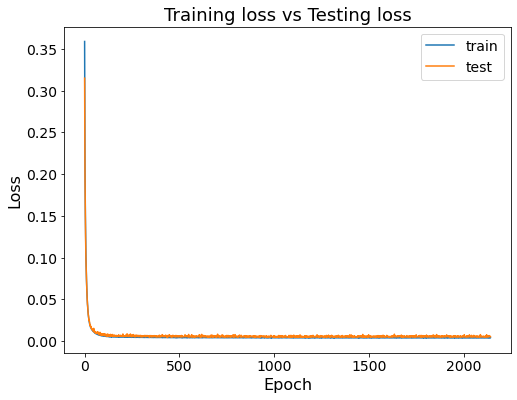

In [31]:
lr = 0.0001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


energy_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/energy_pararcnn_sc1_5layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = energy_pararcnn.fit(train_X, train_y,
                              batch_size=512,
                              epochs=EPOCHS,
                              validation_data=(test_X, test_y),
                              verbose=2,
                              shuffle=True,
                              callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [32]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/energy_pararcnn_sc1_5layer_{}h.h5'.format(K))

In [33]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (6994, 24) (6994, 24)
(6994, 24)


In [34]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 3.471
RMSE = 4.651
